In [ ]:
# Install required packages
# %pip install -r requirements.txt

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# If apple silicon install tensorflow-metal
if os.uname().machine == "arm64":
    %pip install -q tensorflow-metal
    pass

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)
os.makedirs('logs', exist_ok=True)


Training data shape: (88800, 28, 28, 1)
Test data shape: (14800, 28, 28, 1)
Number of classes: 26


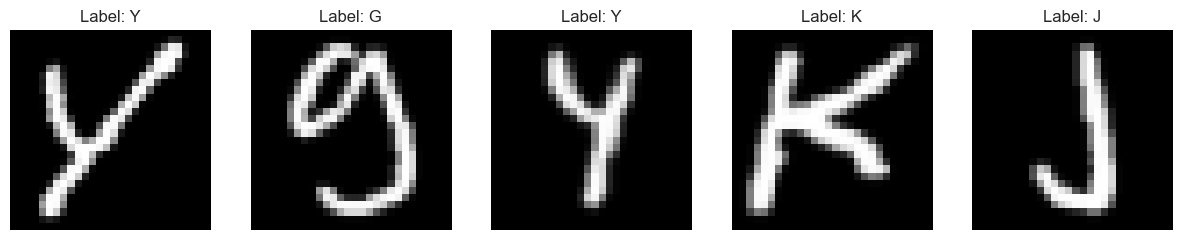

In [12]:
import tensorflow_datasets as tfds
# Load EMNIST dataset
emnist_dataset, emnist_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    as_supervised=True, # Returns tuple (img, label) instead of dict
    batch_size=-1, 
    with_info=True, # Includes dataset metadata
)

# Get the training and test datasets
ds_train, ds_test = emnist_dataset

# now each split is a single (images, labels) pair
x_train, y_train = tfds.as_numpy(ds_train)
x_test,  y_test  = tfds.as_numpy(ds_test)


# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i, :, :, 0].T, cmap='gray')
    plt.title(f'Label: {chr(y_train[i] + 64)}')
    plt.axis('off')
plt.show()


In [13]:
# Preprocess data
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN input (samples, height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")


Preprocessed training data shape: (71040, 28, 28, 1)
Preprocessed validation data shape: (17760, 28, 28, 1)
Preprocessed test data shape: (14800, 28, 28, 1)


In [14]:
from tensorflow import keras
# Create CNN using Keras
def create_cnn_keras(input_shape, num_classes):
    """
    Create a CNN using TensorFlow/Keras.
    
    Requirements:
    - Must use at least 2 convolutional layers
    - Must include pooling and batch normalization
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 85% accuracy on test set
    - Minimize overfitting using batch normalization and dropout
    - Train efficiently with appropriate batch size and learning rate
    
    Args:
        input_shape: Shape of input data (should be (28, 28, 1) for grayscale images)
        num_classes: Number of output classes (26 for letters)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        keras.layers.Input(shape = input_shape),

        # 1st conv block
        keras.layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        
        # 2nd conv block
        keras.layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.3),
        
        # Classifier head
        keras.layers.Flatten(),
        keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'])
    return model

# Create and compile model
model = create_cnn_keras(input_shape=(28, 28, 1), num_classes=26)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │        81,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,762 (393.60 KB)

 Trainable params: 100,570 (392.85 KB)

 Non-trainable params: 192 (768.00 B)

In [15]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CNN(nn.Module):
#     def __init__(self, num_classes):
#         """
#         Create a CNN using PyTorch.
        
#         Requirements:
#         - Must use at least 2 convolutional layers
#         - Must include pooling and batch normalization
        
#         Goals:
#         - Achieve > 85% accuracy on test set
#         - Minimize overfitting using batch normalization and dropout
#         - Train efficiently with appropriate batch size and learning rate
        
#         Args:
#             num_classes: Number of output classes (26 for letters)
#         """
#         super(CNN, self).__init__()
#         [...]
    
#     def forward(self, x):
#         """
#         Forward pass of the network.
        
#         Args:
#             x: Input tensor of shape (batch_size, channels, height, width)
        
#         Returns:
#             Output tensor of shape (batch_size, num_classes)
#         """
#         [...]
#         return x

# # Create model
# model = CNN(num_classes=26)
# print(model)


Epoch 1/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 66s 29ms/step - accuracy: 0.7281 - loss: 1.0345 - val_accuracy: 0.8879 - val_loss: 0.3688 - learning_rate: 0.0010
Epoch 2/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 57s 26ms/step - accuracy: 0.8814 - loss: 0.3797 - val_accuracy: 0.8941 - val_loss: 0.3407 - learning_rate: 0.0010
Epoch 3/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 58s 26ms/step - accuracy: 0.9027 - loss: 0.3000 - val_accuracy: 0.9105 - val_loss: 0.2708 - learning_rate: 0.0010
Epoch 4/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 59s 27ms/step - accuracy: 0.9102 - loss: 0.2599 - val_accuracy: 0.9149 - val_loss: 0.2566 - learning_rate: 0.0010
Epoch 5/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 73s 33ms/step - accuracy: 0.9198 - loss: 0.2349 - val_accuracy: 0.9146 - val_loss: 0.2647 - learning_rate: 0.0010
Epoch 6/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 56s 25ms/step - accuracy: 0.9252 - loss: 0.2143 - val_accuracy: 0.9218 - val_loss: 0.2456 - learning_rate: 0.0010
Epoch 7/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - accura

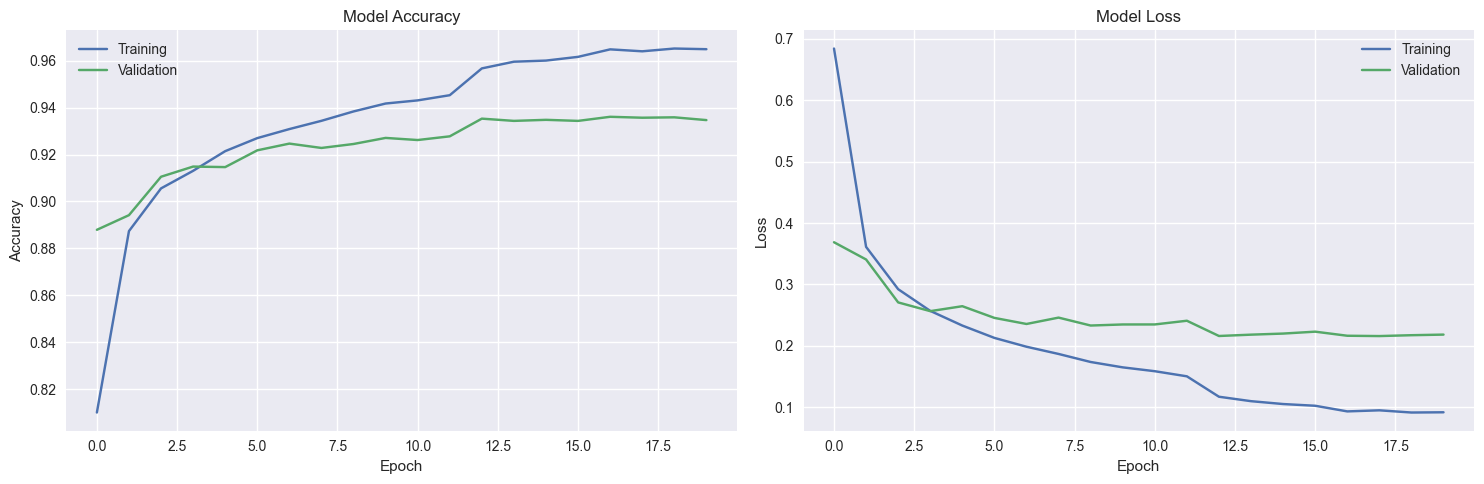

In [16]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/cnn_keras.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
# # Move model to device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters())

# # Convert data to PyTorch tensors
# x_train = torch.FloatTensor(x_train).to(device)
# y_train = torch.LongTensor(np.argmax(y_train, axis=1)).to(device)
# x_val = torch.FloatTensor(x_val).to(device)
# y_val = torch.LongTensor(np.argmax(y_val, axis=1)).to(device)

# # Training loop
# history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
# best_val_loss = float('inf')
# patience = 5
# patience_counter = 0

# for epoch in range(20):
#     # Training
#     model.train()
#     train_loss = 0
#     train_correct = 0
#     train_total = 0
    
#     for i in range(0, len(x_train), 32):
#         batch_x = x_train[i:i+32]
#         batch_y = y_train[i:i+32]
        
#         optimizer.zero_grad()
#         outputs = model(batch_x)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item()
#         _, predicted = outputs.max(1)
#         train_total += batch_y.size(0)
#         train_correct += predicted.eq(batch_y).sum().item()
    
#     train_loss = train_loss / (len(x_train) / 32)
#     train_acc = train_correct / train_total
    
#     # Validation
#     model.eval()
#     val_loss = 0
#     val_correct = 0
#     val_total = 0
    
#     with torch.no_grad():
#         for i in range(0, len(x_val), 32):
#             batch_x = x_val[i:i+32]
#             batch_y = y_val[i:i+32]
            
#             outputs = model(batch_x)
#             loss = criterion(outputs, batch_y)
            
#             val_loss += loss.item()
#             _, predicted = outputs.max(1)
#             val_total += batch_y.size(0)
#             val_correct += predicted.eq(batch_y).sum().item()
    
#     val_loss = val_loss / (len(x_val) / 32)
#     val_acc = val_correct / val_total
    
#     # Save history
#     history['train_loss'].append(train_loss)
#     history['train_acc'].append(train_acc)
#     history['val_loss'].append(val_loss)
#     history['val_acc'].append(val_acc)
    
#     # Early stopping
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         patience_counter = 0
#         # Save best model
#         torch.save(model.state_dict(), 'models/cnn_pytorch.pt')
#         # Save architecture
#         with open('models/cnn_pytorch_arch.txt', 'w') as f:
#             f.write(str(model))
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             break

# # Plot training curves
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# # Plot accuracy
# ax1.plot(history['train_acc'], label='Training')
# ax1.plot(history['val_acc'], label='Validation')
# ax1.set_title('Model Accuracy')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Accuracy')
# ax1.legend()

# # Plot loss
# ax2.plot(history['train_loss'], label='Training')
# ax2.plot(history['val_loss'], label='Validation')
# ax2.set_title('Model Loss')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Loss')
# ax2.legend()

# plt.tight_layout()
# plt.show()


463/463 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9227 - loss: 0.2545
Test accuracy: 0.9231
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/Users/faezehmirlohi/Desktop/UCSF/Assignments/Spring/Datasci223/HM6/6-neural-nets-FaezehMirlohi/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


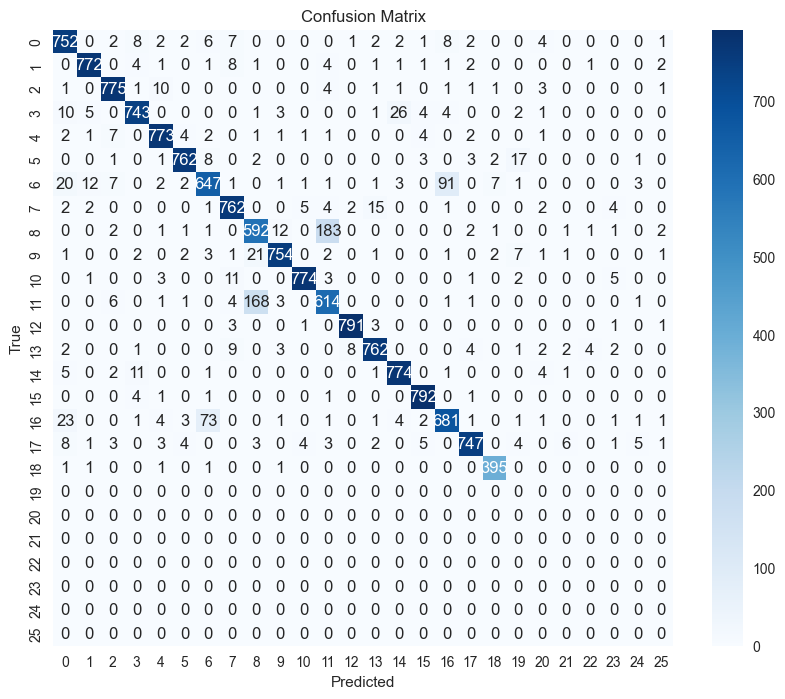

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import os, json

# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Metrics
precision = precision_score(true_labels, predicted_labels, average = 'macro')
recall = recall_score(true_labels, predicted_labels, average = 'macro')
f1 = f1_score(true_labels, predicted_labels, average = 'macro')

# Calculate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save metrics
metrics = {
    'model': 'emnist_classifier',
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_2/cnn_keras_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")
